In [1]:
import requests

### download data ###
url = 'https://github.com/JamyangLotus/Day-and-night-image-classifier/archive/refs/heads/master.zip'
r = requests.get(url, allow_redirects=True)

open('master.zip', 'wb').write(r.content)

28721543

In [2]:
### extract data ###
import zipfile
path_to_zip_file = 'master.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
%cd Day-and-night-image-classifier-master/

/content/Day-and-night-image-classifier-master


In [4]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [5]:
import helpers
import random
image_dir = 'day_night_images/training'
data = helpers.load_dataset(image_dir)
std_data = helpers.standardize_list(data)
random.shuffle(std_data)

240
1
found in 3!


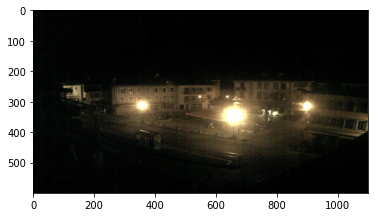

In [6]:
print(len(std_data))
print(std_data[0][1])
for i in range(len(std_data)):
  if(std_data[i][1]==0):
    test_image = std_data[i][0]
    print("found in {}!".format(i))
    break;
plt.imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB));

In [27]:
x = []
y = []
for i in range(len(std_data)):
  x.append(cv2.resize(std_data[i][0],(320,160)))
  y.append(std_data[i][1])

print(len(x),len(y))

240 240


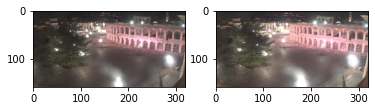

In [8]:
### increasing the brightness of night images###
image = cv2.cvtColor(x[9],cv2.COLOR_BGR2HSV)
for xt in range(image.shape[0]):
  for yt in range(image.shape[1]):
    if (image[:,:,2][xt][yt]*1.3>255):
      image[:,:,2][xt][yt] = 255
    else :
      image[:,:,2][xt][yt] = image[:,:,2][xt][yt]*1.3

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(x[9],cv2.COLOR_BGR2RGB));
ax2.imshow(cv2.cvtColor(image,cv2.COLOR_HSV2RGB));

In [9]:
def augmented_data(data,labels,alpha):
  assert (alpha<1)
  for i in range (len(data)):
    image = cv2.cvtColor(data[i],cv2.COLOR_BGR2HSV)
    label = labels[i]
    for xt in range(image.shape[0]):
      for yt in range(image.shape[1]):
        if label :
          image[:,:,2][xt][yt] = image[:,:,2][xt][yt]*(1-alpha) # decreasing the brightness of day images
        else :
          if (image[:,:,2][xt][yt]*(1+alpha)>255): 
            image[:,:,2][xt][yt] = 255 # saturated pixels
          else :
            image[:,:,2][xt][yt] = image[:,:,2][xt][yt]*(1+alpha) # increasing the brightness of night images
    data.append(cv2.cvtColor(image,cv2.COLOR_HSV2RGB))
    labels.append(label)
  return data,labels

In [28]:
aug_x, aug_y = augmented_data(x,y,0.2)
print(len(aug_x),len(aug_y))

480 480


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import time
import torch.nn.functional as F
from tqdm import tqdm  # For nice progress bar!

In [12]:
def toDevice(data, device):
  
  return data.float().to(device)

In [29]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = torch.Tensor(data)
        self.data = self.data.permute(0, 3, 1, 2)
        print(self.data.shape)
        self.targets = torch.Tensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

dataset = MyDataset(aug_x,aug_y)


torch.Size([480, 3, 160, 320])


In [48]:
num_epochs = 20
learning_rate = 0.0001
validation_split = 0
shuffle_dataset = True
random_seed = 42
num_workers = 2

In [49]:
dataset_size = len(dataset)

print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=num_workers)
print('Training set size: {}'.format(len(train_sampler)))
print('Validation set size: {}'.format(len(valid_sampler)))
# print('Test set size: {}'.format(len(test_loader)))

data_loader_dict = {
    'train': train_loader,
    'val': validation_loader 
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

480
Training set size: 480
Validation set size: 0


In [39]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(16 * 80 * 40, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x


In [50]:
model = CNN(in_channels=3, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        targets = targets.long() 

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")

100%|██████████| 16/16 [00:00<00:00, 33.86it/s]


Accuracy on training set: 100.00


In [52]:
test_dir = 'day_night_images/test'
test_data = helpers.load_dataset(test_dir)
std_test = helpers.standardize_list(test_data)
random.shuffle(std_test)
x_test = []
y_test = []
for i in range(len(std_test)):
  x_test.append(cv2.resize(std_test[i][0],(320,160)))
  y_test.append(std_test[i][1])
test_dataset = MyDataset(x_test,y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

torch.Size([160, 3, 160, 320])
Accuracy on test set: 95.00


In [53]:
def preProcess (path_to_img):
  test_image = cv2.imread(path_to_img)
  test_image = cv2.resize(test_image,(320,160))
  test_tensor = torch.Tensor(test_image)
  test_tensor = test_tensor.permute(2,0,1)
  test_tensor = test_tensor.unsqueeze(0)
  print(test_tensor.shape)
  return test_tensor

torch.Size([1, 3, 160, 320])
NIGHT


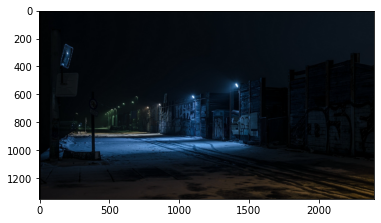

In [56]:
### upload images from web ###
path_to_img = '../street.jpg'
test_tensor = preProcess(path_to_img)
test_tensor = test_tensor.to(device=device)
model.eval()
scores = model(test_tensor)
_, predictions = scores.max(1)
if (predictions.item()):
  print("DAY")
else:
  print("NIGHT")
plt.imshow(cv2.imread(path_to_img));